In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 12
height = 7
plt.rcParams["figure.figsize"] = (width, height)

from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import tflscripts
import json
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn import tree
import pickle
from sklearn.metrics import confusion_matrix

configuration = tflscripts.read_configuration()
df = pd.read_pickle('results.p')

In [2]:
df['f1_without_transfer_r'] = df['f1_wt'].round(1)
df['specificity_r'] = df['specificity'].round(1)

In [3]:
def to_recall_bin(acc):
    bins = [
        [0.0, 0.75],
        [0.75, 1.0]
    ]
    return [i for i, b in enumerate(bins) if b[0] <= acc and b[1] >= acc][0]

df['recall_bin'] = [to_recall_bin(a) for a in df['recall']]

In [ ]:
filtered = df.loc[df.type_of_transfer != 'No transfer']

test_split = 0.33
msk = np.random.rand(len(filtered)) <= test_split
train = filtered[msk]
test = filtered[~msk]

In [ ]:
columns = [
    'features',
    'classifier',
    'label',
    'samples',
    'type_of_transfer',
    'source_device_type',
    'target_device_type',
    'f1_without_transfer_r',
    'specificity_r'
]

def apply_avg(x):
    queried = df.query('features == "{}" & classifier == "{}" & label == "{}" & samples == {} & type_of_transfer == "{}" & source_device_type == "{}" & target_device_type == "{}" & f1_without_transfer_r == "{}" & specificity_r == "{}"'.format(
        x['features'],
        x['classifier'],
        x['label'],
        x['samples'],
        x['type_of_transfer'],
        x['source_device_type'],
        x['target_device_type'],
        x['f1_without_transfer_r'],
        x['specificity_r']
    ))

    if len(queried) > 0:
        median = queried['recall'].median()
        return median

    return -1

aggregated = train[columns]
aggregated = aggregated.drop_duplicates()
aggregated['recall'] = aggregated.apply(apply_avg, axis=1)
aggregated['recall_bin'] = [to_recall_bin(a) for a in aggregated['recall']]

In [ ]:
def to_x_and_y(filtered):
    X = filtered[columns]
    y = filtered['recall_bin']

    X = [dict(r.iteritems()) for _, r in X.iterrows()]
    y = y.values

    return X, y

X_train, y_train = to_x_and_y(aggregated)
X_test, y_test = to_x_and_y(test)

ppl = Pipeline([
    ('vect', DictVectorizer()),
    ('impute', Imputer()),
    ('clf', RandomForestClassifier())
])

ppl.fit(X_train, y_train)
predicted = ppl.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print(accuracy)

In [ ]:
confusion_matrix(y_test, predicted)

In [ ]:
predictions = pd.Series(predicted)
predictions.index = test.index
df['predictions'] = predictions

df.to_pickle('results_with_accuracy_classified.p')

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predicted))

In [14]:
from sklearn.metrics import f1_score, precision_score, recall_score

print('Precision', np.round(precision_score(y_test, predicted, pos_label=1, average='binary'), 2))
print('Recall', np.round(recall_score(y_test, predicted, pos_label=1, average='binary'), 2))
print('F1', np.round(f1_score(y_test, predicted, pos_label=1, average='binary'), 2))

mask_negative = y_test == 0
print('Specificity', np.round(accuracy_score(y_test[mask_negative], predicted[mask_negative]), 2))
print('Accuracy', np.round(accuracy_score(y_test, predicted), 2))

Precision 0.77
Recall 0.46
F1 0.58
Specificity 1.0
Accuracy 0.98


In [ ]:
plt.rcParams["figure.figsize"] = (10, 5)

rf = ppl.named_steps['clf']
importances = pd.Series(rf.feature_importances_)
importances.index = ppl.named_steps['vect'].feature_names_
importances = importances.sort_values(ascending=False)
importances.plot.bar()

In [17]:
categories = {
    'f1_without_transfer': [],
    'specificity': [],
    'samples': [],
    'features': [],
    'type_of_transfer': [],
    'device_type': [],
    'label': [],
    'classifier': []
}

for category in categories:
    for i in importances.index:
        if category in i:
            categories[category] += [importances[i]]
            
df_importances = pd.DataFrame()

for category in categories:
    df_importances = pd.concat([pd.DataFrame({category: pd.Series(categories[category])}), df_importances], axis=1)

df_importances = df_importances.rename(index=str, columns={
    'f1_without_transfer': 'F1 score before transfer',
    'specificity': 'Specificity of target samples',
    'samples': 'Number of training samples',
    'features': 'Sensor channels used',
    'type_of_transfer': 'Type of transfer',
    'device_type': 'Types of sensor boards',
    'label': 'Activity',
    'classifier': 'Classifier'
})

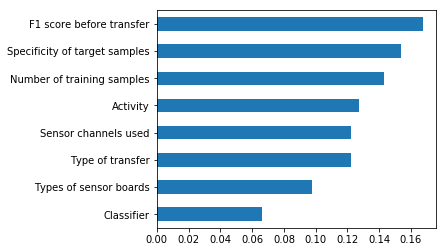

In [18]:
plt.rcParams["figure.figsize"] = (5, 4)
df_importances.sum().sort_values().plot.barh()

In [16]:
1

1